In [8]:
from datetime import datetime

import torch
import torchvision
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import torch.distributions as D
from torch.utils.tensorboard import SummaryWriter
import torch.utils.data as data_util
import matplotlib.pyplot as plt
from IPython import display

In [9]:
# input_shape=28*28
# total_class=12
# random_uniform_val = torch.rand(total_class)
# mean = nn.Parameter(random_uniform_val/random_uniform_val.sum())
# covariance = nn.Parameter(torch.full((total_class,input_shape),1/total_class))
# print(cate)
# print([cate.batch_shape, cate.event_shape])
# mix_model = D.MixtureSameFamily(D.Categorical(mean),
#                                         D.Independent(D.Bernoulli(covariance), reinterpreted_batch_ndims=1))
# print(mix_model)


In [10]:
# import math
# m = nn.Softmax(dim=1)
# n = nn.Softmax(dim=0)
# input = torch.randn(4,1)
# print(input)
# print(m(input))
# print(n(input))
# a = [math.exp(i) for i in input]
# print([ i/sum(a) for i in a ])

In [11]:
transform = transforms.Compose(
    [
        # lambda img: torchvision.transforms.functional.rotate(img, -90),
        # transforms.RandomHorizontalFlip(p=1),
        transforms.ToTensor(),
    ]
)

training_data = datasets.MNIST(root="../data/MINST", download=True, train=True, transform=transform)
# validation_data = datasets.MNIST(root="../data/MINST", download=True, train=False, transform=transform)


train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=100, shuffle=True)
# test_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=100, shuffle=False)

# training_data = torch.asarray([[1.]]*35 + [[0.]]*15 +[[1.]]*15 + [[0.]]*35)
# labels = torch.asarray([1]*100)
# train = data_util.TensorDataset(training_data, labels)
# train_dataloader = data_util.DataLoader(train, batch_size=10, shuffle=True)
for i, data in enumerate(train_dataloader):
    type(data)
    # print(inputs.shape)
    # inputs = torch.reshape(inputs,(10,28*28))
    # inputs = torch.where(inputs > 0, 1.0, 0.0)
    # print(inputs)
    # print(inputs.shape)

    # expanded = inputs.expand(inputs, axis=-1 - len((12,784)))


In [12]:
# softmax = nn.Softmax(dim=0)
# sigmoid = nn.Sigmoid()

# def map_estimate(mles, k=12, dimension=28):
#     #Shrinkage parameter 
#     _lambda = 0.9 
#     mle_to_map = []
#     for i in range(k):
#         print(mles[i].shape)
#         mle_per_class = sigmoid(mles[i])
#         map_per_class = _lambda * torch.diag(torch.diag(mle_per_class)) + (1 - _lambda) * mle_per_class
#         mles[i] = mle_per_class
#     return mles

In [13]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()
    
class Animator:
    """For plotting data in animation."""

    def __init__(
        self,
        xlabel=None,
        ylabel=None,
        legend=None,
        xlim=None,
        ylim=None,
        xscale="linear",
        yscale="linear",
        fmts=("-", "m--", "g-.", "r:"),
        nrows=1,
        ncols=1,
        figsize=(3.5, 2.5),
    ):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        display.set_matplotlib_formats("svg")
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [
                self.axes,
            ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


In [15]:
softmax = nn.Softmax(dim=0)
sigmoid = nn.Sigmoid()

class MNISTModel(nn.Module):

    def __init__(self, total_class = 12, input_shape = 28*28):
        super(MNISTModel, self).__init__()
        random_uniform_val = torch.rand(total_class)
        self.cat_mean = nn.Parameter(random_uniform_val/random_uniform_val.sum())
        self.gauss_mean = nn.Parameter(torch.zeros(input_shape))
        self.gauss_covariance = nn.Parameter(torch.eye(input_shape))

        
    def forward(self,data):
        # _lambda = 0.9 
        # resulting_tensor = self.covariance.clone()
        # resulting_tensor = resulting_tensor.detach()
        # print(self.covariance)
        # for i in range(12):
        #     resulting_tensor[i] = _lambda * torch.diag(torch.diag(resulting_tensor[i])) + (1 - _lambda) * resulting_tensor[i]
        # current_m = self.update(F.softmax(self.mean), F.sigmoid(self.covariance))
        current_m = self.update(softmax(self.cat_mean),softmax(self.gauss_mean), sigmoid(self.gauss_covariance))
        model_prob = current_m.log_prob(data)
        # print(self.mix_model.event_shape)
        # print(len(self.mix_model.event_shape))
        # expanded = torch.unsqueeze(data,len(self.mix_model.event_shape))
        # val1 = self.mix_model.component_distribution.log_prob(expanded) + self.mix_model.mixture_distribution.logits
        # covariance = D.Categorical(logits=val1).probs
        # print(model_prob.shape,covariance.shape)
        return -sum(model_prob)/data.shape[0]
    
    def update(self,cat_mean,gauss_mean,gauss_covariance):
        return D.MixtureSameFamily(D.Categorical(cat_mean),D.MultivariateNormal(gauss_mean,gauss_covariance))

model = MNISTModel()
# ema_model = copy.deepcopy(model)


/var/folders/75/_0h54l8n6ys6k7klg1v8zggh0000gn/T/ipykernel_2103/4004819464.py:33: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats("svg")


IndexError: tuple index out of range

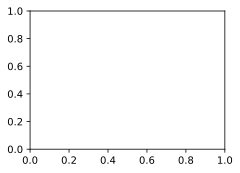

In [16]:
from collections import Counter
from random import randrange

# def update_ema_variables(model, ema_model, ema_decay, k_steps = 49):
#     with torch.no_grad():
#         for ema_param, param in zip(ema_model.parameters(), model.parameters()):
#             ema_new_param = ema_param.data * ema_decay + (1 - ema_decay) * param.data
#             ema_param.data.copy_(ema_new_param)


# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss = nn.MSELoss()

def preprocess_data(inputs):
    batch_size = inputs.shape[0]
    inputs = torch.reshape(inputs,(batch_size,28*28))
    inputs = torch.where(inputs > 0, 1.0, 0.0)
    return inputs

def loss_function(model_predict, actual_labels):
    # l1_regularization = 0.
    # for param in model.parameters():
    #     l1_regularization += param.abs().sum()
    return loss(model_predict,actual_labels)

optimizer = torch.optim.Adam(model.parameters(), lr=0.009, weight_decay=0.0001)
past_steps = 50
def train_one_epoch(animator,epoch):
    last_loss = 0.
    count_elements = [0]*10
    for i, data in enumerate(train_dataloader):
        model.train()
        inputs, labels = data
        
        optimizer.zero_grad()
        # if epoch > 5:
        #     model.enableDropout()
        output = model((preprocess_data(inputs)))
        loss = loss_function(output,labels.float())
        loss.backward()
        optimizer.step()
        # update_ema_variables(model,ema_model,0.99)
        if i%10 == 0:
            model.eval()
            test_inputs, test_labels = next(iter(test_dataloader))
            test_loss = loss_function(model(preprocess_data(test_inputs)),test_labels.float())
            # print('test_loss : ',test_loss.item()/1000)
            animator.add((epoch + i+1), (loss.item()/1000,test_loss.item()/1000)) 
        # else:
            animator.add((epoch + i+1), (loss.item()/1000,None)) 
            # print('train_loss : ',loss.item()/1000)
        counter = Counter(labels.numpy())
        for i in range(10):
            count_elements[i] += counter[i]
          
    print(count_elements)
    return last_loss

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/MNIST_{}'.format(timestamp))
EPOCHS = 20
best_vloss = 1_000_000.
animator = Animator(
        xlabel="epoch", xlim=[1, EPOCHS*len(train_dataloader)], ylim=[0, 100], legend=["train loss", "test loss"]
    )
for epoch in range(EPOCHS):
    model.train(True)
    avg_loss = train_one_epoch(animator,epoch*len(train_dataloader))

    

In [ ]:
model.eval()

figure = plt.figure()
img, label = validation_data[1]
img = torch.reshape(img,(1,28*28))
print(model(torch.where(img > 0, 1.0, 0.0)))
# img = torch.where(img>0, 1.0, 0.0)
# print(img.shape,label)
# plt.imshow(img.permute(1,2,0))

NameError: name 'validation_data' is not defined

<Figure size 640x480 with 0 Axes>

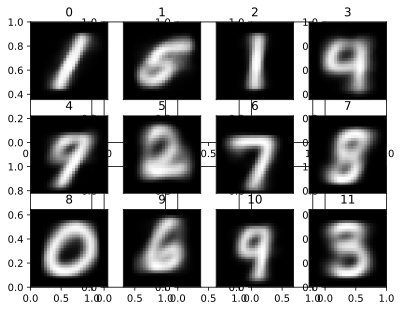

In [11]:
from matplotlib import pyplot as plt

images = sigmoid(list(model.parameters())[1].detach())
fig, axes = plt.subplots(2, 5)
i = 0
for image in images:
    image = image.reshape(28,28)
    plt.subplot(3, 4, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.gray)
    plt.title(i)
    i = i+1
plt.show()
# fig, axes = plt.subplots(3, 4)

# for image,ax in zip(images, axes.flatten):
#     ax.imshow(image.reshape(28, 28), cmap=plt.cm.gray)
#     # ax.set_title("%1.2f" % coeff)
#     ax.axis("off")
#     fig.tight_layout(pad=1.0)
#     plt.show()

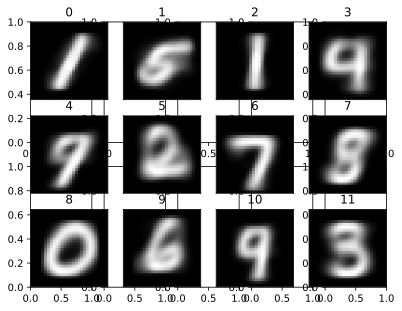

In [10]:
images = sigmoid(list(ema_model.parameters())[1].detach())
fig, axes = plt.subplots(2, 5)
i = 0
for image in images:
    image = image.reshape(28,28)
    plt.subplot(3, 4, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.gray)
    plt.title(i)
    i = i+1
plt.show()

# Sample

In [ ]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

def loss_function(output,model):
    observations = output[0].shape
    return  -sum(output[0])/observations[0]

def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    for i, data in enumerate(train_dataloader):
        inputs, labels = data
        batch_size = inputs.shape[0]
        inputs = torch.reshape(inputs,(batch_size,28*28))
        inputs = torch.where(inputs > 0, 1.0, 0.0)
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        # Make predictions for this batch
        output = model(inputs)
        # Compute the loss and its gradients
        loss = loss_function(output=output,model=model)
        print(loss)
        loss.sum().backward()
        # # Adjust learning weights
        optimizer.step()
        # # Gather data and report
        running_loss += loss.item()
        
        # if i % 1000 == 999:
        #     last_loss = running_loss / 1000 # loss per batch
        #     print('  batch {} loss: {}'.format(i + 1, last_loss))
        #     tb_x = epoch_index * len(train_dataloader) + i + 1
        #     tb_writer.add_scalar('Loss/train', last_loss, tb_x)
        #     running_loss = 0.
    return last_loss

# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/MNIST_{}'.format(timestamp))
epoch_number = 0
EPOCHS = 1
best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()
    # Disable gradient computation and reduce memory consumption.
    # with torch.no_grad():
    #     for i, vdata in enumerate(test_dataloader):
    #         vinputs, vlabels = vdata
    #         voutputs = model(vinputs)
    #         vloss = loss_fn(voutputs, vlabels)
    #         running_vloss += vloss

    # avg_vloss = running_vloss / (i + 1)
    # print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    # writer.add_scalars('Training vs. Validation Loss',
    #                 { 'Training' : avg_loss, 'Validation' : 'avg_vloss' },
    #                 epoch_number + 1)
    # writer.flush()

    # # Track best performance, and save the model's state
    # if avg_vloss < best_vloss:
    #     best_vloss = avg_vloss
    #     model_path = 'model_{}_{}'.format(timestamp, epoch_number)
    #     torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:


IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number